In [23]:
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [24]:
day = -1

market_data = pd.read_csv(f"./round-1-island-data-bottle/prices_round_1_day_{day}.csv", sep=";", header=0)
trade_history = pd.read_csv(f"./round-1-island-data-bottle/trades_round_1_day_{day}.csv", sep=";", header=0)

In [25]:
def autocorrelation(series: np.array, lags):
    # 计算lags阶以内的自相关系数，返回lags个值，分别计算序列均值，标准差
    n = len(series)
    result = [np.correlate(series[i:]-series[i:].mean(), series[:n-i]-series[:n-i].mean())[0]
                / (series[i:].std()*series[:n-i].std()*(n-i))
                for i in range(1, lags+1)]
    return result

/var/folders/pp/zmh040gd59nfqh2pw782lv3m0000gn/T/ipykernel_86380/3768854152.py:4: RuntimeWarning: invalid value encountered in scalar divide
  result = [np.correlate(series[i:]-series[i:].mean(), series[:n-i]-series[:n-i].mean())[0]


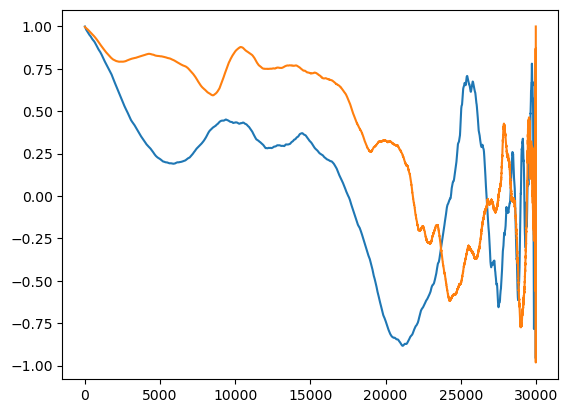

In [27]:
squid_day = []
kelp_day = []

for day in range(-2, 1):

    market_data = pd.read_csv(
        f"./round-1-island-data-bottle/prices_round_1_day_{day}.csv", sep=";", header=0)
    trade_history = pd.read_csv(
        f"./round-1-island-data-bottle/trades_round_1_day_{day}.csv", sep=";", header=0)

    squid_data = market_data[market_data['product']
                             == 'SQUID_INK'].reset_index(drop=True)
    squid_day.append(squid_data['mid_price'].to_numpy())
    
    kelp_data = market_data[market_data['product']
                             == 'KELP'].reset_index(drop=True)
    kelp_day.append(kelp_data['mid_price'].to_numpy())

squid_all = np.concatenate((squid_day[0], squid_day[1], squid_day[2]))
kelp_all = np.concatenate((kelp_day[0], kelp_day[1], kelp_day[2]))

plt.plot(autocorrelation(squid_all, len(squid_all) - 1))
plt.plot(autocorrelation(kelp_all, len(kelp_all) - 1))


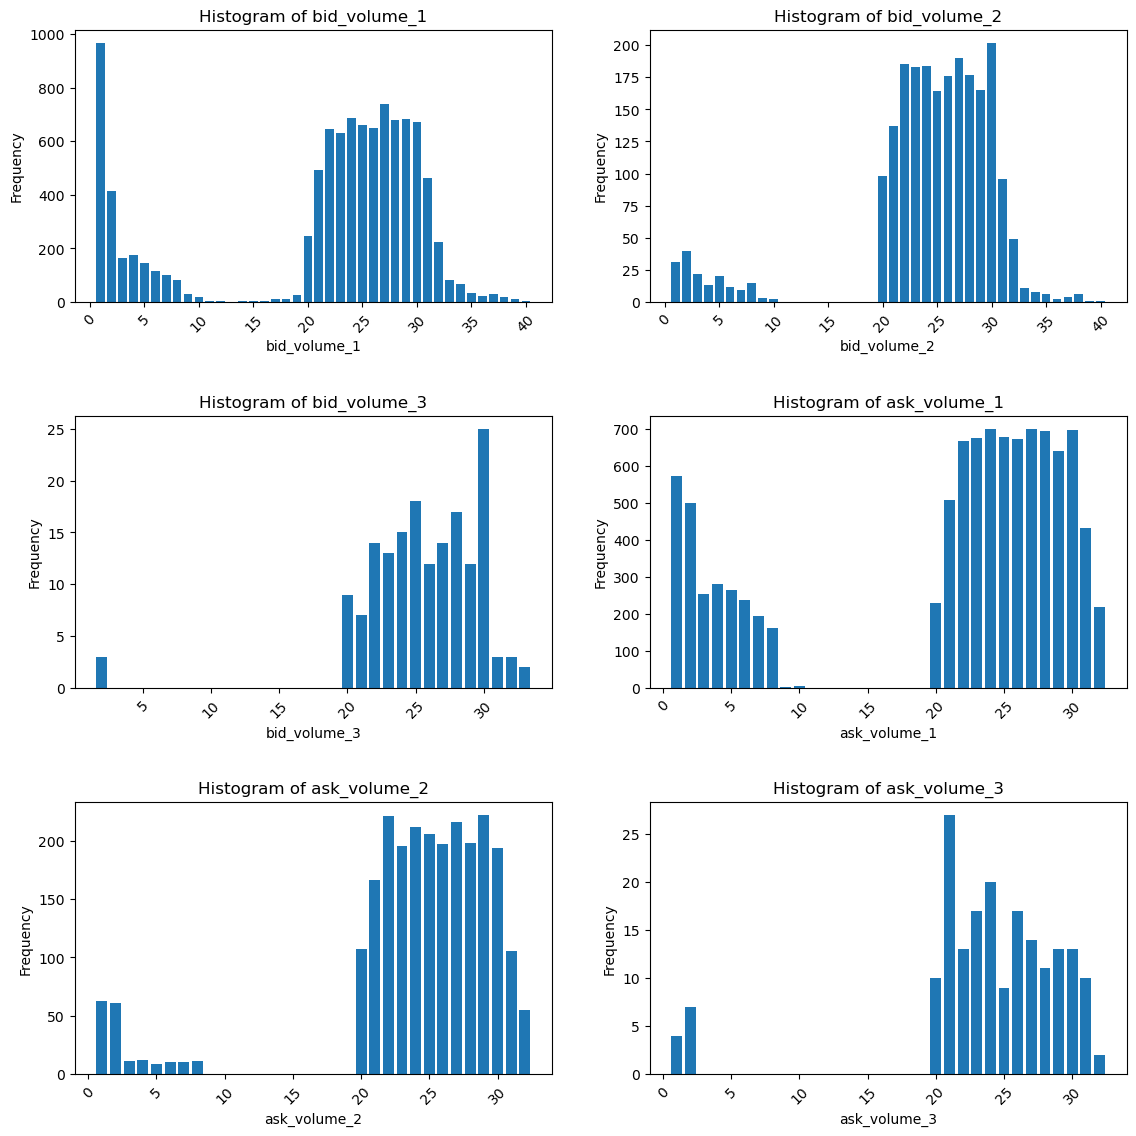

In [3]:
kelp_data = market_data[market_data['product'] == 'SQUID_INK'].reset_index(drop=True)

columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                   'ask_volume_1', 'ask_volume_2', 'ask_volume_3']

num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = kelp_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show()

In [16]:
def calculate_mm_mid(row):
    # Find the best bid with volume >= 20
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= 10:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        best_bid = None

    # Find the best ask with volume >= 20
    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= 10:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        best_ask = None

    # Calculate the mid price if both best bid and ask are found
    if best_bid is not None and best_ask is not None:
        return (best_bid + best_ask) / 2
    else:
        return None

kelp_data['mm_mid'] = kelp_data.apply(calculate_mm_mid, axis=1)

fig = px.line(kelp_data, x='timestamp', y='mm_mid', title='MM Mid Price Over Time')

# Customize the layout
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='MM Mid Price',
)

# Display the plot
fig.show()

In [21]:
CUT_OFF = 15
def calculate_mm_mid(row, cutoff=15):
    # Find the best bid with volume >= 20
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= cutoff:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        best_bid = None

    # Find the best ask with volume >= 20
    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= cutoff:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        best_ask = None

    # Calculate the mid price if both best bid and ask are found
    if best_bid is not None and best_ask is not None:
        return (best_bid + best_ask) / 2
    else:
        return None
    

def calculate_ask_bid_imb(row, cutoff=15):
    
    # Find the best bid volume with volume >= cutoff
    total_bid_volume = 0
    total_ask_volume = 0

    trivial = True
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >=cutoff:
            total_bid_volume += row[f'bid_volume_{i}']
            trivial = False
        else:
            total_bid_volume += 0
    
    if trivial:
        total_bid_volume = None



    trivial = True
    for i in range(1, 4):
        if row[f'ask_volume_{i}']>=cutoff:
            total_ask_volume += row[f'ask_volume_{i}']
            trivial = False
        else:
            total_ask_volume += 0
    
    if trivial:
        total_ask_volume = None

    # If both best bid and ask volumes are available, compute the imbalance
    if total_bid_volume is not None and total_ask_volume is not None:
        imbalance = (total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume)
        return imbalance
    else:
        return None
    

kelp_data['mm_mid'] = kelp_data.apply(calculate_mm_mid, axis=1)
kelp_data['imb'] = kelp_data.apply(calculate_ask_bid_imb, axis=1)

kelp_fair_prices = kelp_data[['timestamp', 'mm_mid', 'imb']]
kelp_fair_prices = kelp_fair_prices.rename(columns={'mm_mid': 'fair'})

iteration_counts = [1,2,5,10,50, 100, 500, 2000] 

for iterations in iteration_counts:
    kelp_fair_prices[f"imb_{iterations}_its_ago"] = kelp_fair_prices['imb'].shift(iterations) * iterations

for iterations in iteration_counts:
    kelp_fair_prices[f"fair_in_{iterations}_its"] = kelp_fair_prices['fair'].shift(-iterations)
    kelp_fair_prices[f"fair_{iterations}_its_ago"] = kelp_fair_prices['fair'].shift(iterations)


for iterations in iteration_counts:
    kelp_fair_prices[f'returns_in_{iterations}_its'] = (kelp_fair_prices[f'fair_in_{iterations}_its'] - kelp_fair_prices['fair'])/kelp_fair_prices['fair']
    kelp_fair_prices[f'returns_from_{iterations}_its_ago'] = (kelp_fair_prices['fair'] - kelp_fair_prices[f'fair_{iterations}_its_ago'])/kelp_fair_prices[f'fair_{iterations}_its_ago']


for iterations in iteration_counts:
    kelp_fair_prices[f'slope_in_{iterations}_its'] = ( kelp_fair_prices[f'fair_in_{iterations}_its'] - kelp_fair_prices[f'fair_{iterations}_its_ago'])


row_names = ['timestamp','fair']
for iterations in iteration_counts:
    row_names.append(f'returns_in_{iterations}_its')
    row_names.append(f"imb_{iterations}_its_ago")
    row_names.append(f"slope_in_{iterations}_its")
    row_names.append(f'returns_from_{iterations}_its_ago')


kelp_returns = kelp_fair_prices[row_names]


kelp_returns= kelp_returns.dropna()

kelp_returns.mean()


timestamp                    498813.097891
fair                           1972.378793
returns_in_1_its                 -0.000002
imb_1_its_ago                     0.005072
slope_in_1_its                   -0.010029
returns_from_1_its_ago           -0.000003
returns_in_2_its                 -0.000002
imb_2_its_ago                     0.010256
slope_in_2_its                   -0.017915
returns_from_2_its_ago           -0.000007
returns_in_5_its                 -0.000011
imb_5_its_ago                     0.025568
slope_in_5_its                   -0.045003
returns_from_5_its_ago           -0.000010
returns_in_10_its                -0.000020
imb_10_its_ago                    0.050729
slope_in_10_its                  -0.083919
returns_from_10_its_ago          -0.000018
returns_in_50_its                -0.000038
imb_50_its_ago                    0.261461
slope_in_50_its                  -0.238128
returns_from_50_its_ago          -0.000062
returns_in_100_its               -0.000230
imb_100_its

test


100%|██████████| 8/8 [00:00<00:00, 670.14it/s]

Iteration Count: 1
Learned Equation: returns_in_1_its = -1.6404 * returns_from_1_its_ago
Train R-squared: 0.0008
Train MSE: 3.0755
Test R-squared: -0.0026
Test MSE: 3.2840

Iteration Count: 2
Learned Equation: returns_in_2_its = -0.2619 * returns_from_2_its_ago
Train R-squared: -0.0003
Train MSE: 5.8052
Test R-squared: -0.0008
Test MSE: 6.0900

Iteration Count: 5
Learned Equation: returns_in_5_its = -0.3741 * returns_from_5_its_ago
Train R-squared: -0.0000
Train MSE: 14.4551
Test R-squared: -0.0007
Test MSE: 15.7799

Iteration Count: 10
Learned Equation: returns_in_10_its = -0.0897 * returns_from_10_its_ago
Train R-squared: -0.0003
Train MSE: 31.8943
Test R-squared: -0.0003
Test MSE: 29.0257

Iteration Count: 50
Learned Equation: returns_in_50_its = 0.0136 * returns_from_50_its_ago
Train R-squared: -0.0002
Train MSE: 142.1418
Test R-squared: -0.0014
Test MSE: 151.3490

Iteration Count: 100
Learned Equation: returns_in_100_its = -0.0984 * returns_from_100_its_ago
Train R-squared: -0.002

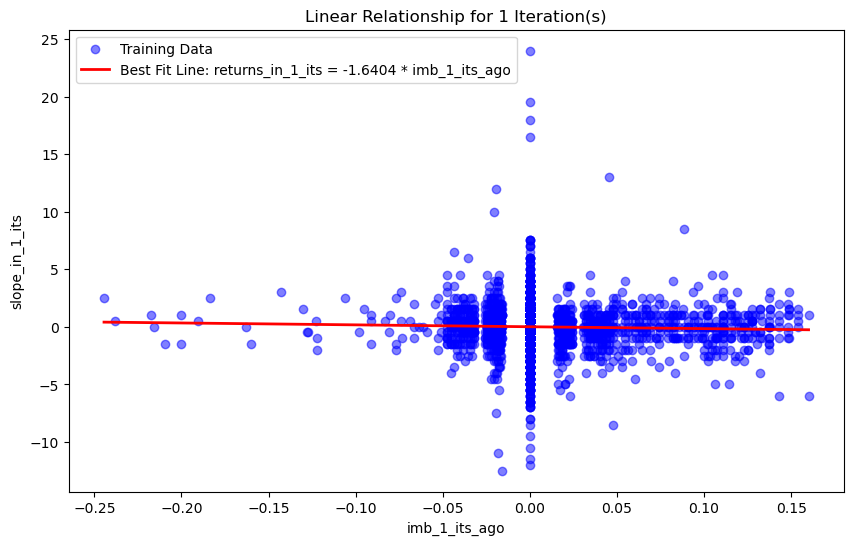

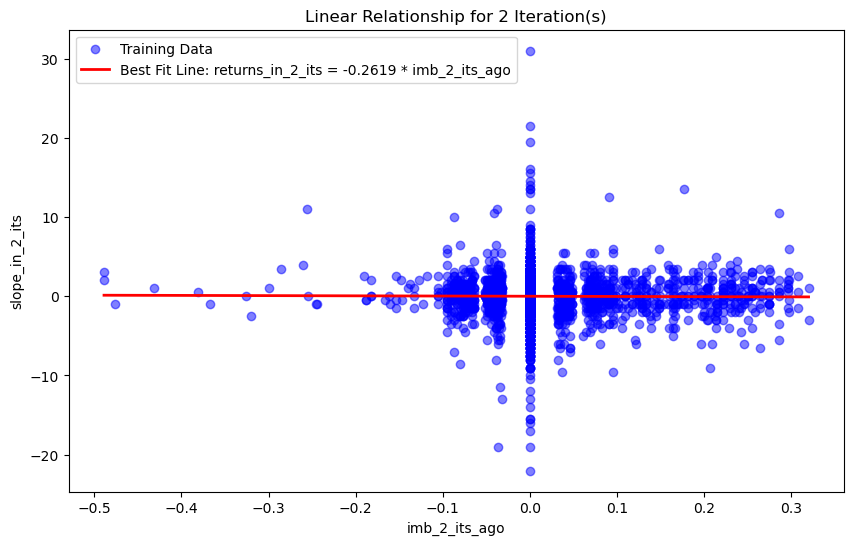

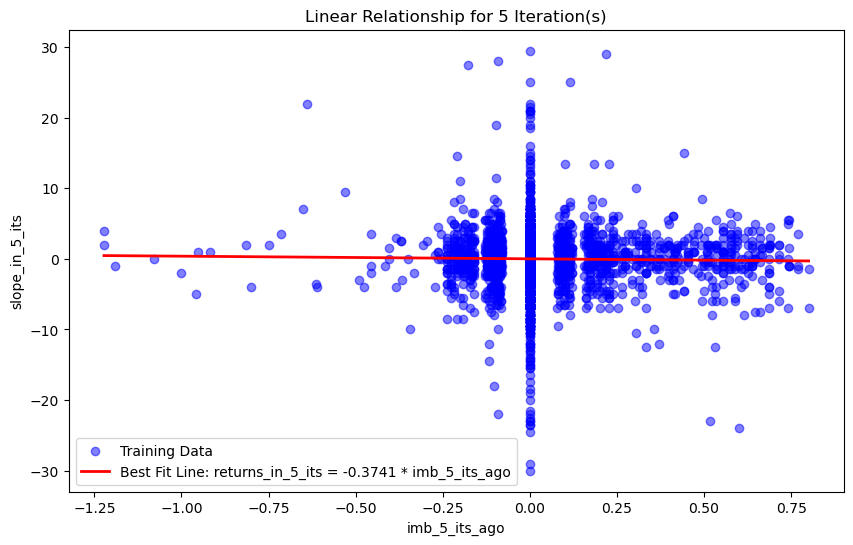

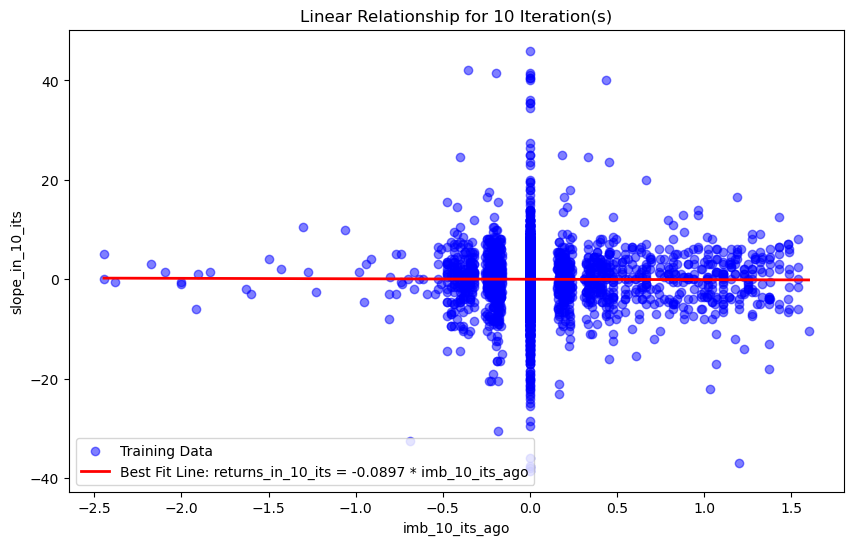

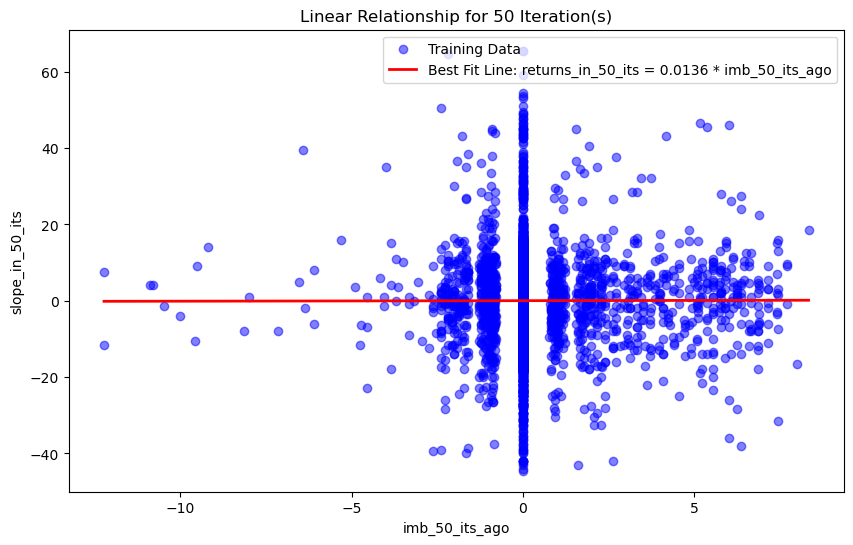

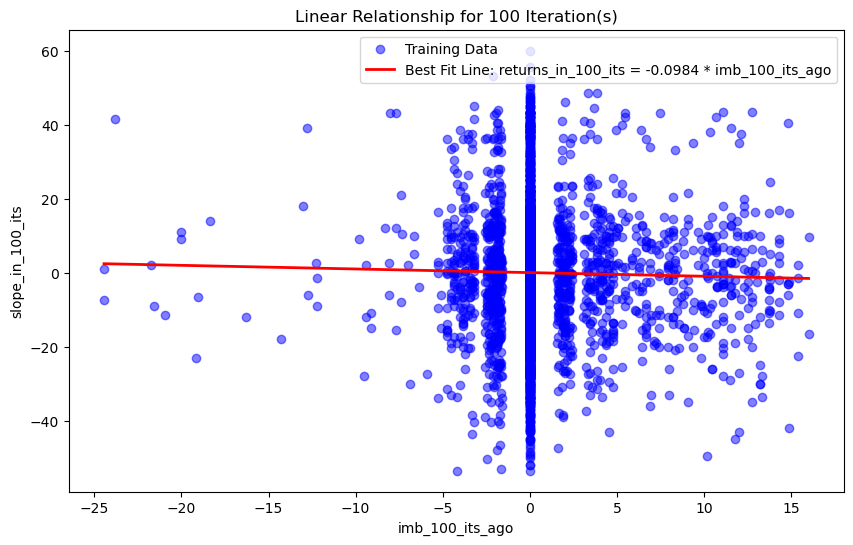

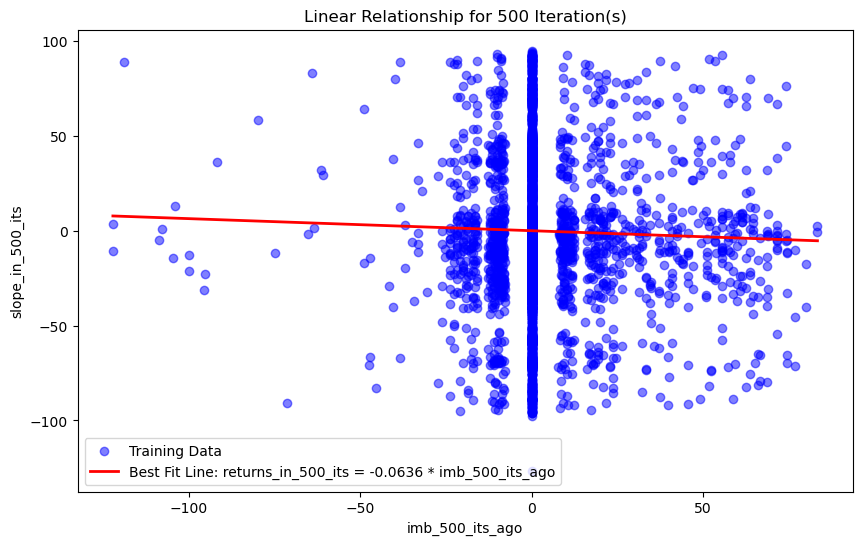

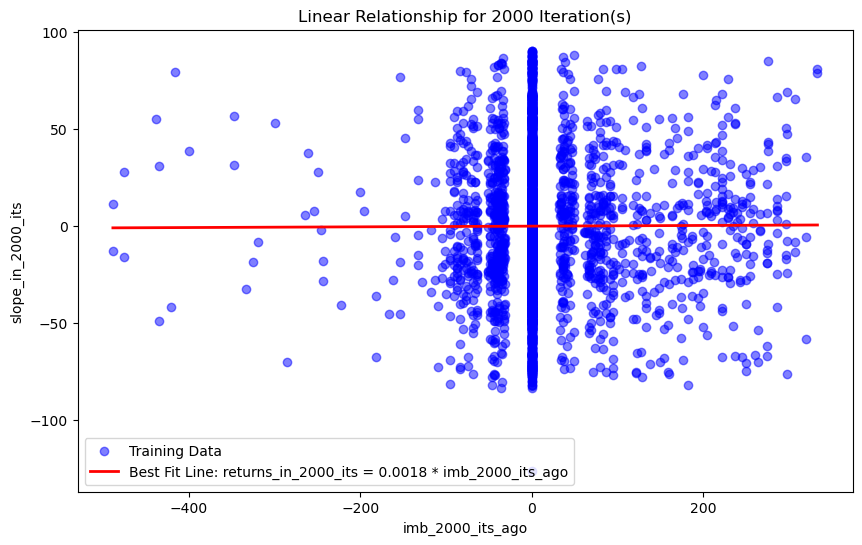

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm

# Perform train-test split
train_data, test_data = train_test_split(kelp_returns, test_size=0.2, random_state=42)

print("test")

# Iterate over each iteration count
for iterations in tqdm(iteration_counts):

    
    # Prepare the feature and target columns
    X_train = train_data[f'imb_{iterations}_its_ago'].values.reshape(-1, 1)
    y_train = train_data[f'slope_in_{iterations}_its']
    
    X_test = test_data[f'imb_{iterations}_its_ago'].values.reshape(-1, 1)
    y_test = test_data[f'slope_in_{iterations}_its']

    # Create and train the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Make predictions on train and test data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Calculate R-squared and MSE for train and test data
    train_r2 = r2_score(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    # Print the results
    print(f"Iteration Count: {iterations}")
    print(f"Learned Equation: returns_in_{iterations}_its = {model.coef_[0]:.4f} * returns_from_{iterations}_its_ago")
    print(f"Train R-squared: {train_r2:.4f}")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test R-squared: {test_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print()

for iteration in iteration_counts:

    # Prepare training data for the chosen iteration count
    X_train = train_data[f'imb_{iteration}_its_ago'].values.reshape(-1, 1)
    y_train = train_data[f'slope_in_{iteration}_its'].values

    # Create and train the linear regression model (without an intercept)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Generate a range of x values for plotting the best fit line
    x_range = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_range)

    # Plot the scatter plot for training data and the best fit line
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training Data')

    plt.plot(x_range, y_line, color='red', linewidth=2, 
            label=f'Best Fit Line: returns_in_{iteration}_its = {model.coef_[0]:.4f} * imb_{iteration}_its_ago')

    plt.xlabel(f'imb_{iteration}_its_ago')
    plt.ylabel(f'slope_in_{iteration}_its')
    plt.title(f'Linear Relationship for {iteration} Iteration(s)')
    plt.legend()
    plt.show()